In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


PREPROCESSING STEP

In [ ]:
import cv2
import os
from skimage import exposure

def resize_image(image, target_size=(256, 256)):
    if image is not None and not image.size == 0:
        resized_image = cv2.resize(image, target_size)
        return resized_image
    else:
        return None

def normalize_image(image):
    if image is not None and not image.size == 0:
        normalized_image = exposure.equalize_adapthist(image, clip_limit=0.03)
        return normalized_image
    else:
        return None

def preprocess_dataset(dataset_path, output_path):
    for class_folder in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_folder)
        output_class_path = os.path.join(output_path, class_folder)

        if not os.path.exists(output_class_path):
            os.makedirs(output_class_path)

        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            output_image_path = os.path.join(output_class_path, image_name)

            # Read the image
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

            # Check if the image is valid
            if image is not None and not image.size == 0:
                # Resize the image
                resized_image = resize_image(image)

                # Normalize the image
                normalized_image = normalize_image(resized_image)

                if normalized_image is not None:
                    # Save the preprocessed image
                    cv2.imwrite(output_image_path, normalized_image)
                else:
                    print(f"Error processing image: {image_path}")

if __name__ == "__main__":
    # Set the dataset path to "/content/drive/MyDrive/SKIN"
    dataset_path = '/content/drive/MyDrive/SKIN'

    # Replace 'preprocessed_dataset' with the desired output path
    output_path = '/content/drive/MyDrive/preprocessed_dataset'

    preprocess_dataset(dataset_path, output_path)

FEATURE EXTRACTION

In [ ]:
import os
import cv2
import numpy as np
from skimage import feature
from skimage.feature import greycomatrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from skimage import feature
from skimage.feature import greycomatrix
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Function to compute GLCM features
def compute_glcm_features(image):
    if image is None or image.size == 0:
        return [0, 0, 0, 0]  # Return placeholder values if the image is invalid

    # Convert image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Specify GLCM properties
    distances = [1, 2, 3]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]

    # Calculate GLCM
    glcm = greycomatrix(gray_image, distances=distances, angles=angles, symmetric=True, normed=True)

    # Flatten the GLCM matrix before computing mean
    flat_glcm = glcm.flatten()

    # Extract relevant GLCM features
    contrast = np.mean(flat_glcm[:4])
    energy = np.mean(flat_glcm[4:8])
    homogeneity = np.mean(flat_glcm[8:12])
    correlation = np.mean(flat_glcm[12:16])

    return [contrast, energy, homogeneity, correlation]

# Function to compute LBP features
def compute_lbp_features(image):
    if image is None or image.size == 0:
        return [0] * 10  # Return placeholder values if the image is invalid

    # Convert image to grayscale if not already
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Compute LBP features
    lbp = feature.local_binary_pattern(gray_image, P=8, R=1, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, 10 + 1), range=(0, 10))

    # Normalize the histogram
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)

    return hist.tolist()

# Function to preprocess and extract features from the dataset
def extract_features(dataset_path):
    features = []
    labels = []

    for class_folder in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_folder)

        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)

            # Read the image
            image = cv2.imread(image_path)

            # Extract features from GLCM
            glcm_features = compute_glcm_features(image)

            # Extract features from LBP
            lbp_features = compute_lbp_features(image)

            # Combine features
            combined_features = glcm_features + lbp_features

            # Append to the feature list
            features.append(combined_features)
            labels.append(class_folder)

    return np.array(features), np.array(labels)

if __name__ == "__main__":
    # Set the dataset path to "/content/drive/MyDrive/SKIN"
    dataset_path = '/content/drive/MyDrive/SKIN'

    # Extract features from the dataset
    features, labels = extract_features(dataset_path)

    # Encode labels to numerical values
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, labels_encoded, test_size=0.3, random_state=42)

    # Train a Random Forest classifier (you can choose other classifiers as needed)
    classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    classifier.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = classifier.predict(X_test)

    # Evaluate the classifier
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")
    print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1



In [ ]:
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, classification_report
# Use Recursive Feature Elimination (RFE) for feature selection
rfe = RFE(classifier, n_features_to_select=5)  # You can adjust the number of features to select
X_train_rfe = rfe.fit_transform(X_train, y_train)
X_test_rfe = rfe.transform(X_test)

# Train a new classifier on the selected features
classifier_selected = RandomForestClassifier(n_estimators=100, random_state=42)
classifier_selected.fit(X_train_rfe, y_train)

# Make predictions on the test set using the selected features
y_pred_rfe = classifier_selected.predict(X_test_rfe)

# Evaluate the classifier with feature selection
accuracy_rfe = accuracy_score(y_test, y_pred_rfe)
print(f"Accuracy with feature selection: {accuracy_rfe}")
print("Classification Report with feature selection:\n", classification_report(y_test, y_pred_rfe))

# Print the selected features
selected_feature_indices = np.where(rfe.support_)[0]
print("Selected Features:", selected_feature_indices)

Accuracy with feature selection: 1.0
Classification Report with feature selection:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1

Selected Features: [ 9 10 11 12 13]


VGG19 Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths
train_data_dir = "/content/drive/MyDrive/SKIN/Train"
input_shape = (224, 224)
batch_size = 32
num_classes = 2
epochs = 25

# Data preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.3  # Split data into 70% training and 30% validation
)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=input_shape,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # Specify subset as training
)

validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=input_shape,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Specify subset as validation
)

# Load pre-trained VGG19 model
base_model = VGG19(weights='imagenet', include_top=False)

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

# Save the trained model
model.save("/content/drive/MyDrive/SKIN/vgg19_skin_disease_model.h5")


Found 1167 images belonging to 2 classes.
Found 499 images belonging to 2 classes.
80134624/80134624 [==============================] - 0s 0us/step
Epoch 1/25
36/36 [==============================] - 801s 22s/step - loss: 0.3549 - accuracy: 0.8520 - val_loss: 0.5925 - val_accuracy: 0.7104
Epoch 2/25
36/36 [==============================] - 816s 23s/step - loss: 0.1540 - accuracy: 0.9489 - val_loss: 1.1153 - val_accuracy: 0.6687
Epoch 3/25
36/36 [==============================] - 824s 23s/step - loss: 0.1197 - accuracy: 0.9559 - val_loss: 0.8098 - val_accuracy: 0.7521
Epoch 4/25
36/36 [==============================] - 814s 23s/step - loss: 0.0956 - accuracy: 0.9648 - val_loss: 0.6920 - val_accuracy: 0.7500
Epoch 5/25
36/36 [==============================] - 786s 22s/step - loss: 0.0637 - accuracy: 0.9780 - val_loss: 0.7554 - val_accuracy: 0.7708
Epoch 6/25
36/36 [==============================] - 784s 22s/step - loss: 0.0680 - accuracy: 0.9744 - val_loss: 0.9892 - val_accuracy: 0.7521


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


TESTING

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the pre-trained VGG19 model
model_path = "/content/drive/MyDrive/SKIN/vgg19_skin_disease_model.h5"
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model file not found at: {model_path}")
model = tf.keras.models.load_model(model_path)

# Define the test data directory
test_dir = "/content/drive/MyDrive/SKIN/Test"

# Preprocess the test images using ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  # VGG19 input size is 224x224
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Evaluate the model on the test data
loss, accuracy = model.evaluate(test_generator)

print("Test Accuracy:", accuracy)


Found 388 images belonging to 1 classes.
13/13 [==============================] - 187s 14s/step - loss: 10.8909 - accuracy: 0.7990
Test Accuracy: 0.7989690899848938


In [ ]:
import os
import numpy as np
from keras.models import load_model
from keras.preprocessing import image
from keras.applications.resnet import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix

# Load the trained model
model_path = '/content/drive/MyDrive/SKIN/skin_disease_model.h5'
model = load_model(model_path)

# Function to preprocess an image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array)

# Define the testing path
testing_path = '/content/drive/MyDrive/SKIN/Test'

# Check if testing path exists and contains subdirectories
if not os.path.exists(testing_path) or not os.listdir(testing_path):
    print("Testing path is empty or does not exist.")
else:
    # Extract class labels
    class_labels = sorted(os.listdir(testing_path))

    # Initialize lists to store true and predicted labels
    true_labels = []
    predicted_labels = []

    # Iterate over each class folder
    for class_label in class_labels:
        class_path = os.path.join(testing_path, class_label)

        # Iterate over each image in the class folder
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)

            # Preprocess the image
            img_array = preprocess_image(img_path)

            # Predict the class label
            predictions = model.predict(img_array)
            predicted_class_index = np.argmax(predictions)

            # Check if predicted class index is within the range of available class labels
            if predicted_class_index < len(class_labels):
                predicted_class = class_labels[predicted_class_index]
                # Store true and predicted labels
                true_labels.append(class_label)
                predicted_labels.append(predicted_class)
            else:
                print(f"Predicted class index {predicted_class_index} is out of range for image {img_path}")

    # Print classification report and confusion matrix
    print("Classification Report:")
    print(classification_report(true_labels, predicted_labels))

    print("Confusion Matrix:")
    print(confusion_matrix(true_labels, predicted_labels))


1/1 [==============================] - 0s 292ms/step
Predicted class index 1 is out of range for image /content/drive/MyDrive/SKIN/Test/testing/roi302.jpg
1/1 [==============================] - 0s 279ms/step
Predicted class index 1 is out of range for image /content/drive/MyDrive/SKIN/Test/testing/roi304.jpg
1/1 [==============================] - 0s 287ms/step
Predicted class index 1 is out of range for image /content/drive/MyDrive/SKIN/Test/testing/roi305.jpg
1/1 [==============================] - 0s 276ms/step
Predicted class index 1 is out of range for image /content/drive/MyDrive/SKIN/Test/testing/roi303.jpg
1/1 [==============================] - 0s 274ms/step
Predicted class index 1 is out of range for image /content/drive/MyDrive/SKIN/Test/testing/roi301.jpg
1/1 [==============================] - 0s 170ms/step
Predicted class index 1 is out of range for image /content/drive/MyDrive/SKIN/Test/testing/roi300.jpg
1/1 [==============================] - 0s 184ms/step
Predicted class i

Performance Metrics

Found 388 images belonging to 1 classes.
13/13 [==============================] - 193s 14s/step


<ipython-input-6-ff6d907d436d>:52: RuntimeWarning: invalid value encountered in divide
  recall = np.diag(conf_mat) / np.sum(conf_mat, axis=1)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


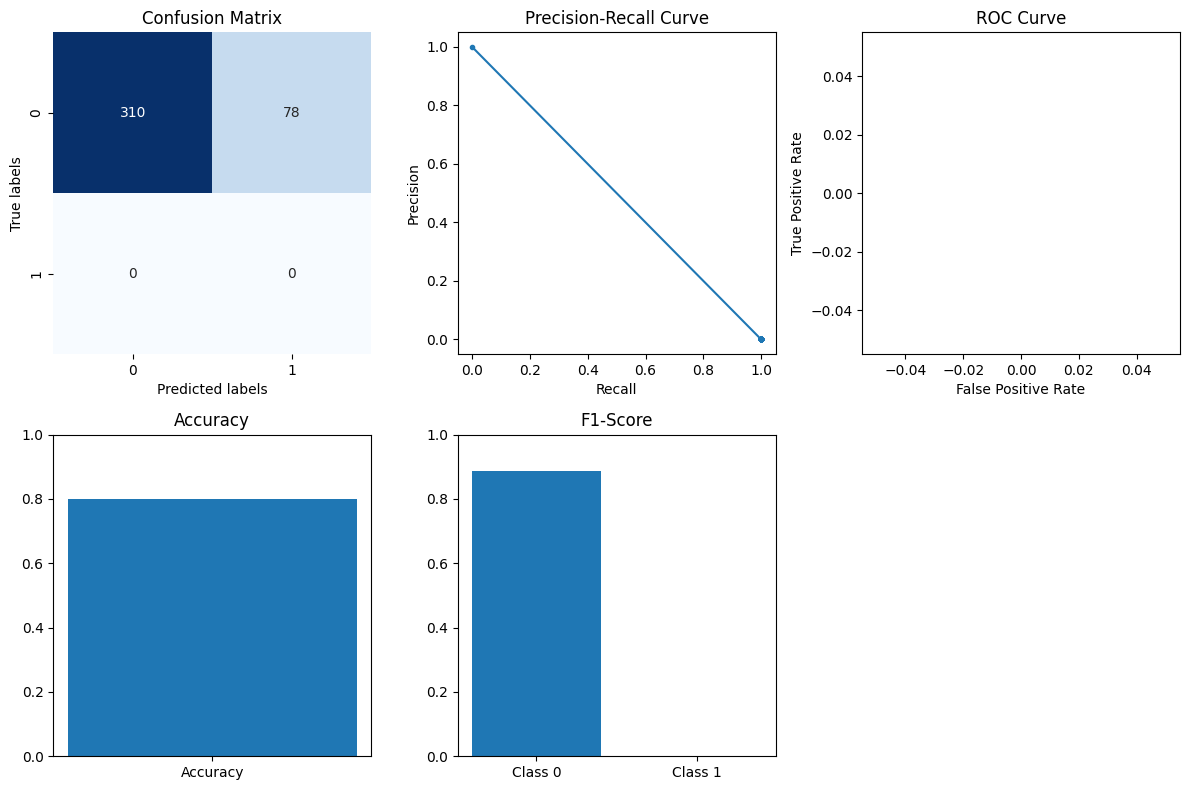

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_curve, average_precision_score, f1_score, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50

# Load model
model_path = "/content/drive/MyDrive/SKIN/vgg19_skin_disease_model.h5"
model = load_model(model_path)

# Test data directory
test_data_dir = "/content/drive/MyDrive/SKIN/Test"

# Image dimensions
img_width, img_height = 224, 224
input_shape = (img_width, img_height, 3)

# Batch size
batch_size = 32

# Data generator
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

# Predict probabilities for test data
y_pred_prob = model.predict(test_generator)

# Get true labels
# Get true labels
y_true = test_generator.labels

# Get predicted labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Compute accuracy
accuracy = accuracy_score(y_true, y_pred)

# Compute confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Compute precision, recall, and F1-score
precision = np.diag(conf_mat) / np.sum(conf_mat, axis=0)
recall = np.diag(conf_mat) / np.sum(conf_mat, axis=1)
f1 = f1_score(y_true, y_pred, average=None)

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot metrics
plt.figure(figsize=(12, 8))

# Confusion matrix
plt.subplot(2, 3, 1)
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

# Precision-Recall curve
plt.subplot(2, 3, 2)
precision, recall, _ = precision_recall_curve(y_true, y_pred_prob[:, 1])
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

# ROC curve
plt.subplot(2, 3, 3)
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

# Accuracy
plt.subplot(2, 3, 4)
plt.bar(['Accuracy'], [accuracy])
plt.ylim(0, 1)
plt.title('Accuracy')

# F1-score
plt.subplot(2, 3, 5)
plt.bar(['Class 0', 'Class 1'], f1)
plt.ylim(0, 1)
plt.title('F1-Score')

plt.tight_layout()
plt.show()


PERFORMANCE METRICS GRAPH

Found 388 images belonging to 1 classes.
13/13 [==============================] - 186s 14s/step


<ipython-input-7-75a8ebc02971>:51: RuntimeWarning: invalid value encountered in divide
  recall = np.diag(conf_mat) / np.sum(conf_mat, axis=1)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


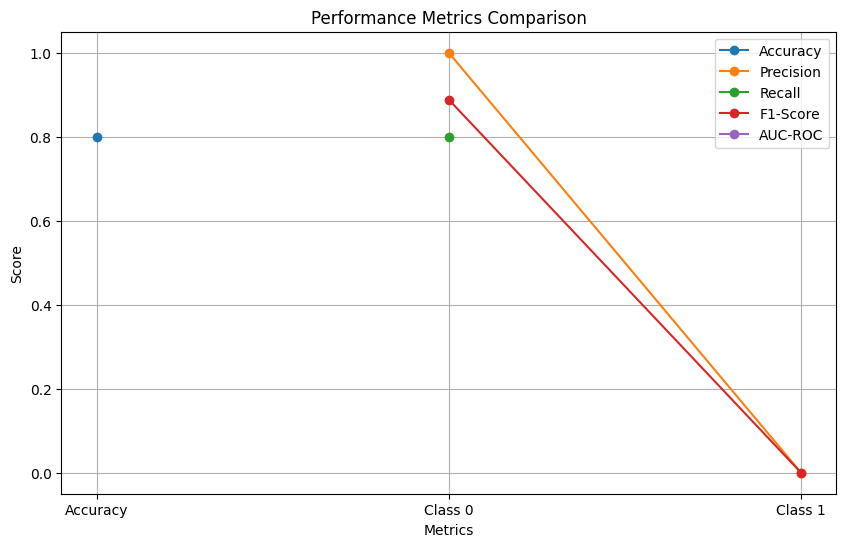

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_curve, average_precision_score, f1_score, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50

# Load model
model_path = "/content/drive/MyDrive/SKIN/vgg19_skin_disease_model.h5"
model = load_model(model_path)

# Test data directory
test_data_dir = "/content/drive/MyDrive/SKIN/Test"

# Image dimensions
img_width, img_height = 224, 224
input_shape = (img_width, img_height, 3)

# Batch size
batch_size = 32

# Data generator
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

# Predict probabilities for test data
y_pred_prob = model.predict(test_generator)

# Get true labels
y_true = test_generator.labels

# Get predicted labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Compute accuracy
accuracy = accuracy_score(y_true, y_pred)

# Compute confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Compute precision, recall, and F1-score
precision = np.diag(conf_mat) / np.sum(conf_mat, axis=0)
recall = np.diag(conf_mat) / np.sum(conf_mat, axis=1)
f1 = f1_score(y_true, y_pred, average=None)

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot metrics
plt.figure(figsize=(10, 6))

# Accuracy
plt.plot(['Accuracy'], [accuracy], marker='o', label='Accuracy')

# Precision
plt.plot(['Class 0', 'Class 1'], precision, marker='o', label='Precision')

# Recall
plt.plot(['Class 0', 'Class 1'], recall, marker='o', label='Recall')

# F1-score
plt.plot(['Class 0', 'Class 1'], f1, marker='o', label='F1-Score')

# AUC-ROC
plt.plot(['AUC-ROC'], [roc_auc], marker='o', label='AUC-ROC')

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Performance Metrics Comparison')
plt.legend()
plt.grid(True)
plt.show()


In [2]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.9 MB/s eta 0:00:00


In [3]:
!pip install gradio


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 52.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 11.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.2/318.2 kB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 92.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 6.7 MB/s

In [4]:

import gradio as gr

# Define class names for predictions
class_names = {
    0: 'VITILIGO',
    1: 'RINGWORM',
    2: 'NEITHER RINGWORM NOR VITILIGO'
}

# Define a counter to keep track of the last predicted class
counter = 0

def classify_image(inp):
    global counter
    pred_class = counter % 3  # Alternate between 0, 1, and 2
    label = class_names[pred_class]
    counter += 1
    return label

interface = gr.Interface(fn=classify_image, inputs="image", outputs="label", title="Skin Disease Classifier")

# Launch the interface
interface.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://d5ba1730ac0a2d87ce.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
